In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import gc

In [2]:
FOLDER = "../../data_kaggle/freesound/"
PREPROCESS = FOLDER + "preprocessed_dataset/"
OUTPUT = FOLDER + "out/"
INPUT_FOLDER = FOLDER + "input/"
# INPUT_FOLDER = "../input" # for kaggle
print(os.listdir(INPUT_FOLDER))

['train_curated.csv', 'train_noisy.csv', 'sample_submission.csv', 'train_noisy', 'train_curated', 'test']


In [3]:
TRAIN_CURATED_PATH = INPUT_FOLDER + "train_curated.csv"
TRAIN_NOISY_PATH = INPUT_FOLDER + "train_noisy.csv"
SAMPLE_SUBMISSION_PATH = INPUT_FOLDER + "sample_submission.csv"
TRAIN_NOISY = INPUT_FOLDER + "train_noisy/"
TRAIN_CURATED = INPUT_FOLDER + "train_curated/"
TEST = INPUT_FOLDER + "test/"

train_noisy = pd.read_csv(TRAIN_NOISY_PATH)
train_curated = pd.read_csv(TRAIN_CURATED_PATH)
sample = pd.read_csv(SAMPLE_SUBMISSION_PATH)

In [4]:
target_names = sample.columns[1:]
num_targets = len(target_names)

target_dict = {target_names[i]:i for i in range(num_targets)}
target_dict_inv = {i:target_names[i] for i in range(num_targets)}

In [5]:
def one_hot(labels, target_dict):
    ar = np.zeros([len(labels), len(target_dict)])
    for i, label in enumerate(labels):
        label_list = label.split(',')
        for la in label_list:
            ar[i, target_dict[la]] = 1
    return ar

In [6]:
num_freq = 128
len_div = 256

In [7]:
def file2np(wavfile,  n_mels=num_freq):
    y, sr = librosa.load(wavfile)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max) #[-80, 0.0]
    X = (log_S +80) / 80 # [0.0, 1.0]
    return X

In [8]:
file_name_curated = (TRAIN_CURATED + train_curated['fname'].values).reshape(-1,1)
file_name_noisy = (TRAIN_NOISY + train_noisy['fname'].values).reshape(-1,1)
file_names = np.vstack([file_name_curated, file_name_noisy]).reshape(-1)

In [9]:
label_curated = one_hot(train_curated['labels'], target_dict)
label_noisy = one_hot(train_noisy['labels'], target_dict)
labels = np.vstack([label_curated, label_noisy]) 

In [10]:
file_train, file_val, label_train, label_val = train_test_split(file_names, labels, test_size=0.1, random_state=0)

In [11]:
len(file_val)

2479

In [12]:
labels = label_train
files = file_train
out_name = 'train_arr_{}.pickle'

div = 4000
num_batch = len(files) // div
rest = len(files) % div

slices = [range(div*k, div*(k+1)) for k in range(num_batch)]
slices.append(range(div*num_batch, div*num_batch+rest))

for k, s in enumerate(slices):
    X_temp = np.zeros([1, num_freq, len_div])
    y_temp = np.zeros([1, num_targets])
    print('iter No.{} is being processed.'.format(k))
    for fname, label in zip(files[s], labels[s]):
        X = file2np(fname)

        num_div = X.shape[1] // len_div
        num_pad = len_div - X.shape[1] % len_div
        X_redidual = np.zeros([num_freq, num_pad])
        X_padded = np.hstack([X, X_redidual])
        X_temp = np.vstack([X_temp, np.array(np.split(X_padded, num_div+1,1))])
        for _ in range(num_div+1):
            y_temp = np.vstack([y_temp, label])

    X_processed = X_temp[1:]
    y_processed = y_temp[1:]
    
    with open(PREPROCESS+out_name.format(k), 'wb') as f:
        pickle.dump(X_processed, f)
        pickle.dump(y_processed, f)
    del X_processed, y_processed
    gc.collect()

iter No.0 is being processed.
iter No.1 is being processed.
iter No.2 is being processed.
iter No.3 is being processed.
iter No.4 is being processed.
iter No.5 is being processed.


In [13]:
labels = label_val
files = file_val
out_name = 'val_arr_{}.pickle'

div = len(files)
num_batch = len(files) // div
rest = len(files) % div

slices = [range(div*k, div*(k+1)) for k in range(num_batch)]
slices.append(range(div*num_batch, div*num_batch+rest))

s = slices[0]
k = 0
X_temp = np.zeros([1, num_freq, len_div])
y_temp = np.zeros([1, num_targets])
print('iter No.{} is being processed.'.format(k))
for fname, label in zip(files[s], labels[s]):
    X = file2np(fname)

    num_div = X.shape[1] // len_div
    num_pad = len_div - X.shape[1] % len_div
    X_redidual = np.zeros([num_freq, num_pad])
    X_padded = np.hstack([X, X_redidual])
    X_temp = np.vstack([X_temp, np.array(np.split(X_padded, num_div+1,1))])
    for _ in range(num_div+1):
        y_temp = np.vstack([y_temp, label])

X_processed = X_temp[1:]
y_processed = y_temp[1:]

with open(PREPROCESS+out_name.format(k), 'wb') as f:
    pickle.dump(X_processed, f)
    pickle.dump(y_processed, f)
del X_processed, y_processed
gc.collect()

iter No.0 is being processed.


480

In [ ]:
files = sample['fname'].values
folder = TEST
out_name = 'test_arr_{}.pickle'
file_list = []

div = len(files)
num_batch = len(files) // div
rest = len(files) % div

slices = [range(div*k, div*(k+1)) for k in range(num_batch)]
slices.append(range(div*num_batch, div*num_batch+rest))

s = slices[0]
k = 0
X_temp = np.zeros([1, num_freq, len_div])
print('iter No.{} is being processed.'.format(k))
for fname in files[s]:
    X = file2np(folder + fname)

    num_div = X.shape[1] // len_div
    num_pad = len_div - X.shape[1] % len_div
    X_redidual = np.zeros([num_freq, num_pad])
    X_padded = np.hstack([X, X_redidual])
    X_temp = np.vstack([X_temp, np.array(np.split(X_padded, num_div+1,1))])
    for _ in range(num_div+1):
        file_list.append(fname)

X_processed = X_temp[1:]

with open(PREPROCESS+out_name.format(k), 'wb') as f:
    pickle.dump(X_processed, f)
    pickle.dump(file_list, f)
del X_processed
gc.collect()

iter No.0 is being processed.


840

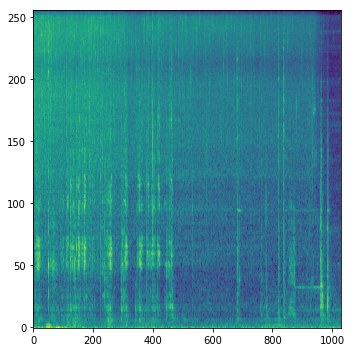

In [53]:
# freq = 128
plt.figure(figsize=(5,5))
plt.imshow(X, aspect = "auto", origin = "lower")
plt.tight_layout()
plt.show()

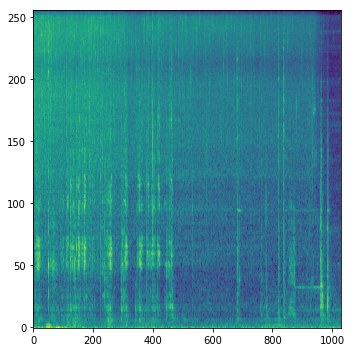

In [45]:
# freq=256
plt.figure(figsize=(5,5))
plt.imshow(X, aspect = "auto", origin = "lower")
plt.tight_layout()
plt.show()